# Tutorial part 3

In [part 1](part1.ipynb) and [part 2](part2.ipynb) we have learnt about portfolio lines. These are timeseries, or collections of timeseries, describing the volumes and/or prices during various delivery periods.

In this part, we'll combine portfolio lines into a "portfolio state" (``PfState``) object. As we'll see, some of the methods and properties we know from the ``PfLine`` class also apply here.


## Example data

Let's again use the mock functions to get some portfolio lines. (The parameter details here are not important, we just want some more-or-less realistic data). To change things up a bit from the previous tutorial parts, we'll look at about 80 days in the autumn of 2024, in quarterhourly (``"15T"``) resolution. And let's localize the data to a specific timezone:

In [1]:
import portfolyo as pf
import pandas as pd

index = pd.date_range('2024-09-20', '2024-12-10', freq='15T', inclusive='left', tz='Europe/Berlin')
# Creating offtake portfolio line.
ts_offtake = -1 * pf.dev.w_offtake(index, avg=50)
offtake = pf.PfLine({'w': ts_offtake})
# Creating portfolio line with market prices (here: price-forward curve).
ts_prices = pf.dev.p_marketprices(index, avg=200)
prices = pf.PfLine({'p': ts_prices})

# Creating portfolio line with sourced volume.
ts_sourced_power1, ts_sourced_price1 = pf.dev.wp_sourced(ts_offtake, 'QS', 0.3, p_avg=120)
sourced_quarters = pf.PfLine({'w': ts_sourced_power1, 'p': ts_sourced_price1})
ts_sourced_power2, ts_sourced_price2 = pf.dev.wp_sourced(ts_offtake, 'MS', 0.2, p_avg=150)
sourced_months = pf.PfLine({'w': ts_sourced_power2, 'p': ts_sourced_price2})
sourced = pf.MultiPfLine({'quarter_products': sourced_quarters, 'month_products': sourced_months})

We can now use these portfolio lines to create a portfolio state.

## Portfolio State

The ``PfState`` class is used to hold information about offtake, market prices, and sourcing. Let's create one from the portfolio lines we just created:

In [2]:
pfs = pf.PfState(offtake, prices, sourced)

pfs

PfState object.
. Timestamps: first: 2024-09-20 00:00:00+02:00     timezone: Europe/Berlin
               last: 2024-12-09 23:45:00+01:00         freq: <15 * Minutes> (7780 datapoints)
                                                w           q           p             r
                                               MW         MWh     Eur/MWh           Eur
──────── offtake
           2024-09-20 00:00:00 +0200        -46.1         -12                          
           2024-09-20 00:15:00 +0200        -44.6         -11                          
           ..                                  ..          ..          ..            ..
           2024-12-09 23:30:00 +0100        -59.7         -15                          
           2024-12-09 23:45:00 +0100        -58.5         -15                          
─●────── pnl_cost
 │         2024-09-20 00:00:00 +0200         46.1          12      137.41         1 583
 │         2024-09-20 00:15:00 +0200         44.6          11      136.45   

Note from how these portfolio lines were created, that ``offtake`` has negative values. The sign conventions are discussed [here](../core/pfstate.rst#sign-conventions).

This portfolio state contains values for every quarterhour in the specified time period. Let's see what features this class has, starting with two methods we already met when discussing the ``PfLine`` class.

### Plotting

Just as when working with portfolio lines, we can get a quick overview of the portfolio state with the ``.plot()`` method...

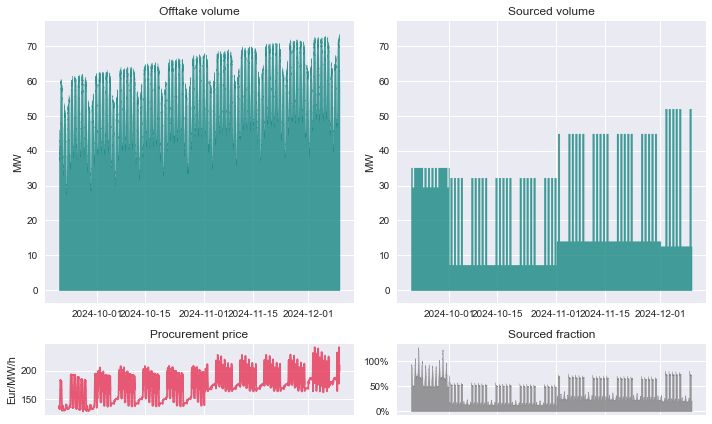

In [3]:
pfs.plot();

...and we can copy it to the clipboard, or save it as an Excel workbook:

In [4]:
pfs.to_clipboard()
pfs.to_excel('portfolio_state.xlsx')

Looking at the offtake, we can see the daily and weekly cycles, as well as a slow increase over the entire time period.

This graph is a bit too detailed for most purposes, so let's look at the second method we know from ``PfLine``: resampling.

### Resampling

We might prefer to see hourly, daily, or monthly values instead of the quarterhourly values that are in ``pfs``. For this, we can resample the object with the ``.asfreq()`` method. In this code example, we also use the ``.print()`` method, which adds some helpful coloring to the output:

In [5]:
pfs_monthly = pfs.asfreq('MS')
pfs_monthly.print()

PfState object.
. Timestamps: first: 2024-10-01 00:00:00+02:00     timezone: Europe/Berlin
               last: 2024-11-01 00:00:00+01:00         freq: <MonthBegin> (2 datapoints)
                                                w           q           p             r
                                               MW         MWh     Eur/MWh           Eur
──────── offtake
           2024-10-01 00:00:00 +0200        -54.7     -40 752                          
           2024-11-01 00:00:00 +0100        -59.4     -42 737                          
─●────── pnl_cost
 │         2024-10-01 00:00:00 +0200         54.7      40 752      168.95     6 885 143
 │         2024-11-01 00:00:00 +0100         59.4      42 737      182.50     7 799 446
 ├●───── sourced
 ││        2024-10-01 00:00:00 +0200         16.5      12 330      124.06     1 529 630
 ││        2024-11-01 00:00:00 +0100         24.9      17 899      145.51     2 604 524
 │├───── quarter_products
 ││        2024-10-01 00:00:00 +0200  

Note how the resampled output only contains those months, that are *entirely* included in the original data. ``pfl`` has data in September and December, but as these are not present in their entirety, they are dropped from ``pfl_monthly``.

### On frequencies and unsourced prices

There is one other important consequence of resampling: the unsourced prices are now *specific for this portfolio*. We can demonstrate this by creating a second portfolio state, using the *same price-forward curve* (but different offtake and sourced volume):

In [6]:
pfs2 = pf.PfState(offtake*1.5, prices, sourced*2)

At this shortest frequency, the unsourced prices are identical (namely, the price-forward curve). Let's create a dataframe with the prices to verify this:

In [7]:
pd.DataFrame({'pfs': pfs.unsourcedprice.p, 'pfs2': pfs2.unsourcedprice.p, 'hpfc': prices.p})

,pfs,pfs2,hpfc
2024-09-20 00:00:00+02:00,139.80568207211454,139.80568207211454,139.80568207211454
2024-09-20 00:15:00+02:00,135.63901540544785,135.63901540544785,135.63901540544785
2024-09-20 00:30:00+02:00,131.47234873878116,131.47234873878116,131.47234873878116
2024-09-20 00:45:00+02:00,128.13901540544785,128.13901540544785,128.13901540544785
2024-09-20 01:00:00+02:00,124.80568207211451,124.80568207211451,124.80568207211451
...,...,...,...
2024-12-09 22:45:00+01:00,217.88078474854294,217.88078474854294,217.88078474854294
2024-12-09 23:00:00+01:00,221.2141180818763,221.2141180818763,221.2141180818763
2024-12-09 23:15:00+01:00,224.54745141520962,224.54745141520962,224.54745141520962
2024-12-09 23:30:00+01:00,227.88078474854294,227.88078474854294,227.88078474854294


However, at every other frequency, they are not equal. When changing the frequency, a *volume-weighted* average is calculated for the unsourced prices - just like with every other price-and-volume timeseries. This makes that the unsourced prices apply only to the unsourced volume profile *of that portfolio*:

In [8]:
pd.DataFrame({'pfs': pfs.asfreq('MS').unsourcedprice.p, 'pfs2': pfs2.asfreq('MS').unsourcedprice.p, 'hpfc': prices.asfreq('MS').p})

,pfs,pfs2,hpfc
2024-10-01 00:00:00+02:00,188.42508393359162,181.24498173050412,194.7888872946484
2024-11-01 00:00:00+01:00,209.1531673069816,196.4928389978348,220.07479863375985


This has important consequences. 

For example, when doing a scenario analysis in which the unsourced volume is changed (e.g. "what happens if the offtake increases by 50%?"), we cannot expect the results to be correct *unless we are working at the original frequency*. In situations where it is clear that this error looms, a ``UserWarning`` is shown to alert the user - see the examples further below.

For this reason, we commonly work with our porfolio states at the frequency of the price-forward curve. Downsampling is only done to see the aggregated values for verification or reporting.

### Components

Now, let's look at the portfolio state ``pfs_monthly`` in a bit more detail, to learn more about the ``PfState`` class.

The portfolio state is presented to us as a tree structure, with several branches. Each branch is a portfolio line. E.g, ``offtake`` and ``sourced`` are the portfolio lines we specified when creating the object. Also, the branch ``pnl_cost`` is the sum of ``sourced`` and ``unsourced``, with ``sourced`` being the sum of ``quarter_products`` and ``month_products``. 

The unsourced volume is found by comparing the offtake to what is already sourced. This volume is valued at the market prices in the forward curve.

These portfolio lines can be obtained from the portfolio state by accessing them as attributes. E.g. ``.offtakevolume``, ``.sourced``, ``.unsourced``, or ``.pnl_cost``. The latter is the best estimate for what it will cost to procure the offtake:

In [9]:
pfs_monthly.pnl_cost

PfLine object with price and volume information.
. Timestamps: first: 2024-10-01 00:00:00+02:00     timezone: Europe/Berlin
               last: 2024-11-01 00:00:00+01:00         freq: <MonthBegin> (2 datapoints)
. Children: 'sourced' (price and volume), 'unsourced' (price and volume)
                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-10-01 00:00:00 +0200         54.7      40 752      168.95     6 885 143
2024-11-01 00:00:00 +0100         59.4      42 737      182.50     7 799 446

Notice that this portfolio line has children, and as a reminder, we can "drill into" the object to get these nested portfolio line, e.g. with ``pfl_monthly.pnl_cost["sourced"]``.

There are some other components that are not explicitly shown:

* We may be interested in how much of the offtake has already been sourced or unsourced. These fractions are available at the ``.sourcedfraction`` and ``.unsourcedfraction`` properties.

* You may have noticed that ``unsourced`` is the inverse from what traders would call the "open positions" or "portfolio positions": if our portfolio is short, the unsourced volume is positive. For those that prefer this other perspective, it is available at ``.netposition``.

### Export

Just as with portfolio lines, we can create an excel file that contains all the information in a portfolio state with its ``.to_excel()`` method, and we can copy it to the clipboard with the ``.to_clipboard()`` method.

### MtM

We can evaluate the value of our sourcing contracts against the current forward curve ("mark-to-market") with the ``.mtm_of_sourced()`` method.

## Analyses with portfolio states

We'll now look at how we can do "what-if" analyses with portfolio state. The original portfolio state we will consider as the reference and store it in an appropriately named variable:

In [10]:
ref = pfs

The monthly procurement prices of this portfolio are what interest us the most. As a reminder, we can find the procurement volumes and costs with:

In [11]:
cost_ref = ref.asfreq('MS').pnl_cost
cost_ref

PfLine object with price and volume information.
. Timestamps: first: 2024-10-01 00:00:00+02:00     timezone: Europe/Berlin
               last: 2024-11-01 00:00:00+01:00         freq: <MonthBegin> (2 datapoints)
. Children: 'sourced' (price and volume), 'unsourced' (price and volume)
                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-10-01 00:00:00 +0200         54.7      40 752      168.95     6 885 143
2024-11-01 00:00:00 +0100         59.4      42 737      182.50     7 799 446

(Or we could go one step further and focus on only the prices with ``ref.asfreq("MS").pnl_cost.p``.)

### Change in offtake

Now, what would happen if the offtake were to increase by 25%? Qualitatively, this is not hard. An increase in the offtake increases the unsourced volume. And because the market prices are higher than what we pay for the sourced volume, this means that the procurement price will go up. 

How much? Let's see. First, we create a new portfolio state, from the reference, by setting the offtake to the new value. We can do this with the ``.set_offtake()`` method. After that, we can again see what the procurement volumes and costs are. (Note the ``UserWarning`` which was mentioned [above](#on-frequencies-and-unsourced-pricesE).)

In [12]:
higherofftake = ref.offtakevolume * 1.25
pfs_higherofftake = ref.set_offtakevolume(higherofftake)
cost_higherofftake = pfs_higherofftake.asfreq("MS").pnl_cost
cost_higherofftake

c:\users\ruud.wijtvliet\ruud\python\dev\portfolyo\portfolyo\core\pfstate\pfstate.py:186: UserWarning: This operation changes the unsourced volume. This causes inaccuracies in its price if the portfolio has a frequency that is longer than the spot market.
  warnings.warn(


PfLine object with price and volume information.
. Timestamps: first: 2024-10-01 00:00:00+02:00     timezone: Europe/Berlin
               last: 2024-11-01 00:00:00+01:00         freq: <MonthBegin> (2 datapoints)
. Children: 'sourced' (price and volume), 'unsourced' (price and volume)
                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-10-01 00:00:00 +0200         68.4      50 940      175.42     8 935 754
2024-11-01 00:00:00 +0100         74.2      53 421      191.18    10 213 276

Comparing these two ``cost`` portfolio lines, we see that indeed the values for ``w`` and ``q`` have increased to 125% of the original values. Also, the procurement prices have increased. We can quickly calculate by how much:

In [13]:
cost_higherofftake.p - cost_ref.p

2024-10-01 00:00:00+02:00    6.464917091070561
2024-11-01 00:00:00+01:00     8.68510126846661
Freq: MS, Name: p, dtype: pint[Eur/MWh]

We could similarly create a portfolio states for situations with a market price drop of 40%. Or one which combines both effects:

In [14]:
lowerprices = ref.unsourcedprice * 0.6
pfs_lowerprices = ref.set_unsourcedprice(lowerprices)
pfs_lowerprices_higherofftake = ref.set_offtakevolume(higherofftake).set_unsourcedprice(lowerprices)

c:\users\ruud.wijtvliet\ruud\python\dev\portfolyo\portfolyo\core\pfstate\pfstate.py:186: UserWarning: This operation changes the unsourced volume. This causes inaccuracies in its price if the portfolio has a frequency that is longer than the spot market.
  warnings.warn(


## Hedging

Hedging can reduce the sensitivity of our portfolio to changes in the market price. Given the current market price curve, we can calculate how much we'd need to source to obtain a fully hedged portfolio:

In [15]:
needed = ref.hedge_of_unsourced("val", "MS")  # value hedge with month products

Let's say we procure exactly that volume. We can add it to the sourced volume in our portfolio state:

In [16]:
hedged = ref.add_sourced(pf.MultiPfLine({"newvolume": needed}))

c:\users\ruud.wijtvliet\ruud\python\dev\portfolyo\portfolyo\core\pfstate\pfstate.py:196: UserWarning: This operation changes the unsourced volume. This causes inaccuracies in its price if the portfolio has a frequency that is longer than the spot market.
  warnings.warn(


The portfolio is now hedged at the month level. We can verify this by looking at the unsourced volume. In case of a volume hedge, the unsourced volume (``q`` and ``w``) is 0, even if its monetary value (``r``) is not; in case of a value hedge, it is the reverse:

In [17]:
hedged.asfreq('MS').unsourced

PfLine object with price and volume information.
. Timestamps: first: 2024-10-01 00:00:00+02:00     timezone: Europe/Berlin
               last: 2024-11-01 00:00:00+01:00         freq: <MonthBegin> (2 datapoints)
                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-10-01 00:00:00 +0200         -0.2        -174       -0.00             0
2024-11-01 00:00:00 +0100         -0.2        -134       -0.00             0

Because the market prices have not changed, the best-estimate procurement prices (at month level and longer) are also unchanged from before. (This is verified in the "before" columns of the dataframe further below.)

### Market price change

A hedged profile is less impacted by market price changes. To see that this is indeed the case, let's look at a scenario with an increase in the forward price curve by 40 Eur/MWh, for both portfolio states:

In [18]:
newprices = prices + pf.Q_(40, 'Eur/MWh')
ref_higherprices = ref.set_unsourcedprice(newprices)
hedged_higherprices = hedged.set_unsourcedprice(newprices)

The reference portfolio has gotten a lot more expensive, whereas the procurement price for the hedged portfolio has not moved significantly:

In [19]:
pd.DataFrame({
    ('ref', 'before'): ref.pnl_cost.asfreq('MS').p, 
    ('ref', 'after'): ref_higherprices.pnl_cost.asfreq('MS').p, 
    ('hedged', 'before'): hedged.pnl_cost.asfreq('MS').p, 
    ('hedged', 'after'): hedged_higherprices.pnl_cost.asfreq('MS').p,
}).pint.dequantify()

ref                  hedged            
                               before       after      before       after
unit                          Eur/MWh     Eur/MWh     Eur/MWh     Eur/MWh
2024-10-01 00:00:00+02:00  168.951354  196.849227  168.951354  168.780582
2024-11-01 00:00:00+01:00  182.499117  205.746369  182.499117  182.373550

For the observant reader: it may seem that the portfolio was not fully hedged after all, as a small change in the procurement price is seen. The reason is that each strategy (i.e., volume or value hedge) fully protects only against a specific price change (i.e., absolute or relative). A volume hedge does not *fully* hedge against an absolute price change such as the one we see here.

This tutorial is continued [in part 4](part4.ipynb).